<h1>Hapax compounds</h1>

In [1]:
import os
import re
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set()
import json
import numpy as np

# Define charts settings
plt.rc('xtick',labelsize=14)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["legend.framealpha"] = 1

# Select whether the experiment should be replicated or whether to fix bugs
fix_bugs = True

<h3>Load data</h3>

In [2]:
# Load list of compounds

with open(os.path.join('src', 'unique_compounds.txt'),"r") as input_dict:
    list_of_words=[]
    for line in input_dict:
        # ORIGINAL
        if not fix_bugs:
            # BUG: There are remaining \t signs in some words, e.g. 'þunwange\t'
            list_of_words+=line.strip("\n.").split(" ")
        # BUG FIXED
        else:
            wrds = line.strip("\n.").split(" ")
            list_of_words += [w.strip() for w in wrds]

In [3]:
# Load all words in corpus
with open(os.path.join('src', 'calgary_proce_x.txt'),"r") as input_file:
    words=[]
    for line in input_file:
        words+=line.strip("\n.").split(" ")

In [4]:
# Count compounds frequencies in entire corpus
frequencies = defaultdict(int)

for dword in list_of_words:
    if len(dword) <= 3:
        continue
    for word in words:
        if dword in word:
            frequencies[dword] += 1    

In [5]:
# Locate compounds in particular texts
title = ''
lineno = 1
linenobeo = 1
endline = '#'
locations = defaultdict(lambda: defaultdict(list))
line_counts = defaultdict(int)

for word in words:
    if '{' in word or '}' in word:
        if lineno > 1:
            line_counts[title] = lineno
        title = re.sub('[\{\}]', '', word)
        # Fix inconsitency in the name of Christ III
        title = re.sub('christ3iii', 'christiii', title)
        lineno = 1
    if '#' in word:
        lineno += 1
        if title.startswith('beowulf'):
            linenobeo += 1
    if len(word) <= 3:
        continue
    
    for dword in list_of_words:
        is_compound = False
        # ORIGINAL
        if not fix_bugs:
            # BUG: it should be 'in' as above not '==' - to capture inflected words
            if dword == word:
                is_compound = True
        # BUG FIXED
        else:
            if dword in word:
                is_compound = True

        if is_compound:
            # ORIGINAL
            if not fix_bugs:
                # BUG: second key should be dword - it may differ due to inflection
                locations[title][word].append(lineno)
                if title.startswith('beowulf'):
                    locations['beowulf'][word].append(linenobeo)
            # BUG FIXED
            else:
                locations[title][dword].append(lineno)
                if title.startswith('beowulf'):
                    locations['beowulf'][dword].append(linenobeo)

<h3>Get list of hapax compounds</h3>

In [6]:
hapaxes = [dword for dword in frequencies if frequencies[dword] == 1]

<h3>Define function to plot hapax curves and regression lines</h3>

In [7]:
def plot_hapax_curve(titles, hapaxes, locations, max_=None, hlines=dict()):
    '''
    titles:    [list] of titles that should be plotted | 'all' to plot all the documents
    hapaxes:   [list] of hapax compounds
    locations: {dict of {dicts of [lists]} giving information on where the hapaxes appear in particular texts
    max_:      max number of compounds to be plotted, default: None
    hlines:    {dict of [lists]} giving information on where to plot the horizontal lines with the structure
               hlines[title] = [y1, y2...], default: empty {dict}
    '''

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
    colors = 'bgrcmyk'
    i = 0
    
    # If titles=='all' instead of {dict}, load all keys in locations
    if isinstance(titles, str) and titles == 'all':
        titles = sorted(locations.keys())
    
    # Iterate over titles
    for title in titles:

        # Track occurrences of hapax compounds (y-values)
        y = list()
        for compound in locations[title]:
            if compound in hapaxes:
                y.extend(locations[title][compound])
        y.sort()

        # If max_ defined, slice list to given length
        if max_:
            y = y[0:max_]

        # 
        x = range(0, len(y))

        # Plot data into chart
        ax.scatter(x, y, alpha=0.8, c=colors[i], s=30, label=title)

        # Plot regression line and print out slope and r
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        regression_line = slope*x+intercept        
        ax.plot(x, regression_line, alpha=0.8, c=colors[i])
        print('{0}: slope = {1}, r = {2}'.format(title, round(slope, 2), r_value))

        # Plot horizontal lines if specified for this title
        if title in hlines:
            for hy in hlines[title]:
                hx = (hy - intercept)/slope
                ax.plot([hx-15, hx+15], [hy, hy], c=colors[i])
        
        i += 1
        
    plt.legend(loc=2)
    plt.show()

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Replicate Figures</h3>
<p>
First we replicate Fig. 2c: the curve for Beowulf
<ul><li>The result seems correct</li></ul>


beowulf: slope = 13.54, r = 0.9991850912311456


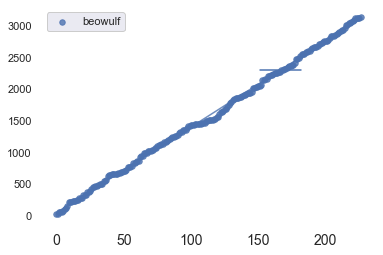

In [8]:
plot_hapax_curve(['beowulf'], hapaxes, locations, hlines={'beowulf':[2300]})

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's proceed to figures in the supplement. We start with the most general one: 
Supplement. Fig. 2c giving data on (1) Christ and Satan, (2) Juliana, (3) Elene, (4) Andreas, 
(5) Beowulf, and (6) Exodus
The figure is obviously limited to display only first 60 or so compounds, we therefore pass max_=60
<ul><li>The result seems correct</ul></li>

christandsatan: slope = 55.45, r = 0.967989788334351
juliana: slope = 32.41, r = 0.9393449290246665
elene: slope = 28.29, r = 0.991973483802167
andreas: slope = 22.7, r = 0.995113753620932
beowulf: slope = 13.77, r = 0.9944709569943808
exodus: slope = 9.53, r = 0.9864721808066099


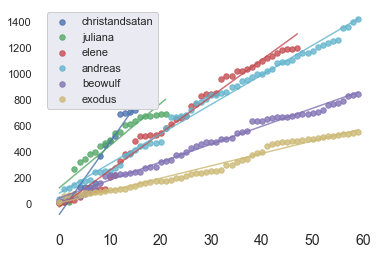

In [9]:
plot_hapax_curve(['christandsatan', 'juliana', 'elene', 'andreas', 'beowulf', 'exodus'], hapaxes, locations, max_=60)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Now Supplement Fig. 2A: Two samples from Genesis A and Genesis B
<ul><li>Data obviously does not correspond to how they are described in the article 
("We partitioned Genesis A into two random sections that are of comparable length to Genesis B)
but instead consists of (1) Genesis B, (2) part of Genesis A preceding B, (3) long part of A following B</ul></li>

genesisA1: slope = 23.19, r = 0.9846739453269441
genesisB: slope = 29.5, r = 0.981123933608576
genesisA2: slope = 21.12, r = 0.9920407460890228


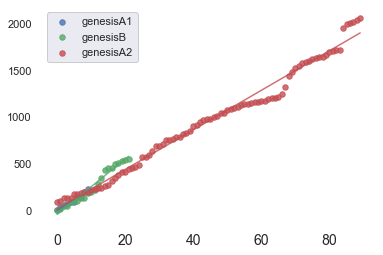

In [10]:
plot_hapax_curve(['genesisA1', 'genesisB', 'genesisA2'], hapaxes, locations)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's try to make samples for Fig. 2A on ouw own.
<p> We define two new functions: (1) to merge two texts together (in this case GenesisA1 and GenesisA2) and (2) to partition text into samples (in this case GenesisA1+2 into two samples of length corresponding to length of GenesisB

<ul><li>The result seems more or less correct (the samples may have been defined in different way originally)</ul></li>

genesisA1: slope = 20.95, r = 0.9719813440586889
genesisA2: slope = 23.15, r = 0.9932262206997875
genesisB: slope = 29.5, r = 0.981123933608576


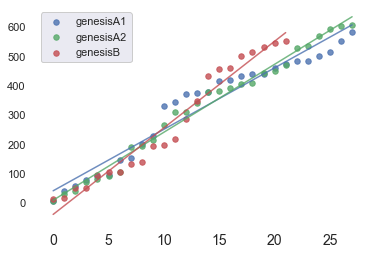

In [11]:
def merge(titles, locations, line_counts):
    '''
    titles:       [list] of titles that should be plotted | 'all' to plot all the documents
    locations:    {dict of {dicts of [lists]} giving information on where the hapaxes 
                  appear in particular texts
    line_counts:  {dict} giving the number of lines in each text
    '''
    
    locations_merged = defaultdict(lambda: defaultdict(list))
    lines_before = 0
    merged_title = ' - '.join(titles)
    
    for title in titles:
        for w in locations[title]:
            for l in locations[title][w]:
                locations_merged[merged_title][w].append(l+lines_before)
        lines_before += line_counts[title]

    return locations_merged

def samples(title, locations, sample_size, number_of_samples):
    '''
    title:              title from which samples should be taken from
    locations:          {dict of {dicts of [lists]} giving information on where the hapaxes 
                        appear in particular texts
    sample_size:        how many lines should sample contain
    number_of_samples:  how many samples to create
    '''
    
    locations_samples = defaultdict(lambda: defaultdict(list))
    
    for i in range(0, number_of_samples):
        for w in locations[title]:
            for l in locations[title][w]:
                if l > i * sample_size and l <= (i+1) * sample_size:
                    locations_samples['{0}_{1}'.format(title, i+1)][w].append(l-i*sample_size)
    
    return locations_samples

genesisA_merged = merge(['genesisA1', 'genesisA2'], locations, line_counts)
genesisA_samples = samples('genesisA1 - genesisA2', genesisA_merged, line_counts['genesisB'], 2)
genesis = {
    'genesisA1': genesisA_samples['genesisA1 - genesisA2_1'],
    'genesisA2': genesisA_samples['genesisA1 - genesisA2_2'],
    'genesisB': locations['genesisB'],
    
}
plot_hapax_curve('all', hapaxes, genesis)        

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Finally Supplement Fig. 3b: Three random partitions of Exodus.
<p>Lets' simply try to split Exodus into 3 parts of the same length.
<ul><li>Now this is a very different result. Instead of having three similar regression lines, the slope for sample 2 is almost twice as bigger as for sample 1 and 3</ul></li>

exodus_1: slope = 6.36, r = 0.9783212657457848
exodus_2: slope = 11.38, r = 0.9753106438071025
exodus_3: slope = 6.17, r = 0.9704865495753849


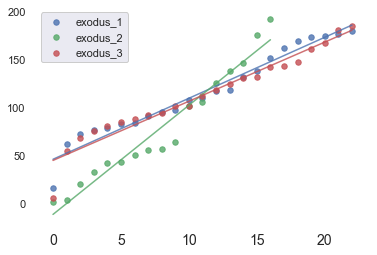

In [12]:
sample_size = math.floor(line_counts['exodus']/3)
exodus_samples = samples('exodus', locations, sample_size, 3)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's try partitioning into 4 samples
<ul><li>Once again there are big differences in slopes</ul></li>

exodus_1: slope = 5.89, r = 0.9420369798269473
exodus_2: slope = 7.25, r = 0.9854512048911095
exodus_3: slope = 15.48, r = 0.9896034623066985
exodus_4: slope = 5.65, r = 0.991254126884212


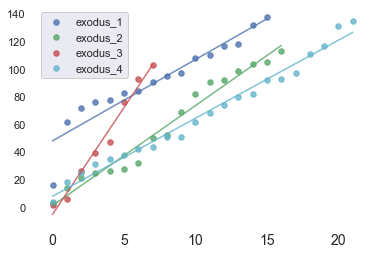

In [13]:
sample_size = math.floor(line_counts['exodus']/4)
exodus_samples = samples('exodus', locations, sample_size, 4)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Further experiments</h3>
<p>
<ul><li>Partitioning Elene into two halves gives the difference very similar to Genesis A vs. Genesis B</li></ul>


elene_1: slope = 31.25, r = 0.9792473652436587
elene_2: slope = 22.67, r = 0.979885468687283


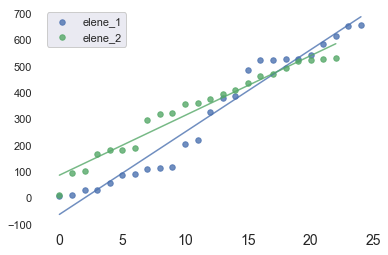

In [14]:
sample_size = math.floor(line_counts['elene']/2)
exodus_samples = samples('elene', locations, sample_size, 2)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
<ul><li>Differences are striking for two halves of Juliana and Daniel, the values are far from linear fit</li></ul>


juliana_1: slope = 81.94, r = 0.9219914176349302
juliana_2: slope = 22.11, r = 0.9681816512457819


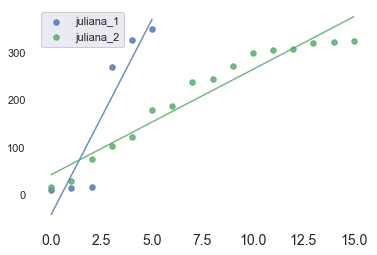

daniel_1: slope = 44.92, r = 0.9574041046241124
daniel_2: slope = 83.6, r = 0.9492476663324084


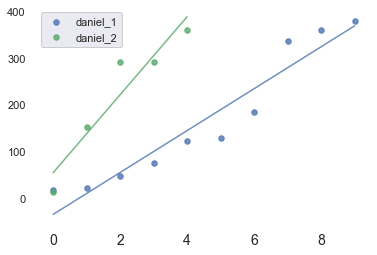

In [15]:
sample_size = math.floor(line_counts['juliana']/2)
exodus_samples = samples('juliana', locations, sample_size, 2)
plot_hapax_curve('all', hapaxes, exodus_samples)

sample_size = math.floor(line_counts['daniel']/2)
exodus_samples = samples('daniel', locations, sample_size, 2)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
<ul><li>This is what happens when we merge some of the longest texts together: there's no evidence that they should be of the same authorship, but the quality of fit is not far from that of Beowulf. This shows how tricky this plotting method is.</li></ul>


beowulf: slope = 13.54, r = 0.9991850912311456
elene - genesisB - phoenix: slope = 28.05, r = 0.998268008334914
genesisA - andreas: slope = 23.88, r = 0.9971529083298395


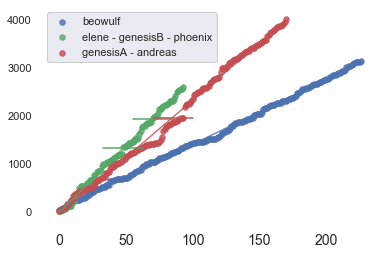

In [16]:
locations_temp = merge(['elene', 'genesisB', 'phoenix'], locations, line_counts)
locations2_temp = merge(['genesisA1', 'genesisA2', 'andreas'], locations, line_counts)

for x in locations2_temp:
    locations_temp['genesisA - andreas'] = locations2_temp[x]

hlines = {
    'elene - genesisB - phoenix': [
        line_counts['elene'], 
        line_counts['elene'] + line_counts['genesisB'], 
    ],
    'genesisA - andreas': [
        #line_counts['genesisA1'], 
        line_counts['genesisA1'] + line_counts['andreas'], 
    ],    
}

    
locations_temp['beowulf'] = locations['beowulf']
plot_hapax_curve('all', hapaxes, locations_temp, hlines=hlines)                


In [17]:
# ADDITION: Function for generating random partitions, computing slope differences, and plotting summary histogram

def parttest(title,n,finale_=None):    
    y = list()
    for compound in locations[title]:
        if compound in hapaxes:
            y.extend(locations[title][compound])
    y.sort()
    slopediff=list()
    slopelist=list()
    raw_data = []
    for trial in range(0,999):
        partit=np.random.randint(0.2*np.max(y),0.8*np.max(y))
        y1=[i for i in y if i < partit]
        y2=[i for i in y if i >= partit]
        x1 = range(0, len(y1))
        x2 = range(0, len(y2))
        slope1, intercept, r_value, p_value, std_err = stats.linregress(x1,y1)
        slope2, intercept, r_value, p_value, std_err = stats.linregress(x2,y2)
        slopediff.append(abs(slope2-slope1))
        slopelist.append(slope2)
        slopelist.append(slope1)
    slopediff.sort()
    if finale_:
        partit=finale_
        y1=[i for i in y if i < partit]
        y2=[i for i in y if i >= partit]
        x1 = range(0, len(y1))
        x2 = range(0, len(y2))
        slope1, intercept, r_value, p_value, std_err = stats.linregress(x1,y1)
        slope2, intercept, r_value, p_value, std_err = stats.linregress(x2,y2)
        slopediff.append(abs(slope2-slope1))
        print(abs(slope1-slope2)/np.average(slopelist))
    f=plt.figure()
    plt.hist(slopediff/np.average(slopelist), bins = n)
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rc('xtick', labelsize=12)     
    plt.rc('ytick', labelsize=12)
    plt.xlabel('percent difference in slope', fontsize=12)
    plt.ylabel('count', fontsize=12)
    plt.show()
    f.savefig("foo.pdf", bbox_inches='tight')
    raw_data = slopediff/np.average(slopelist)
    return raw_data

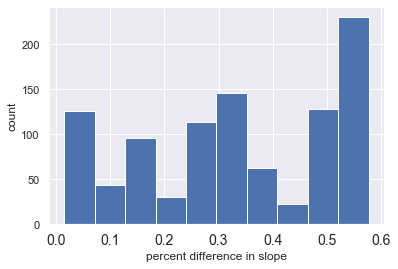

In [18]:
# ADDITION: Exodus distribution (Fig. S1)
raw_data_exodus = parttest('exodus',10)

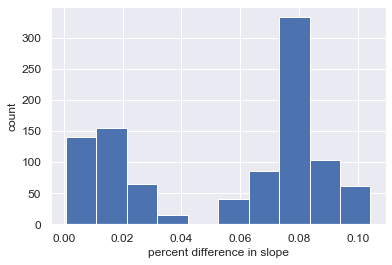

In [19]:
# ADDITION: Beowulf distribution (Fig. S1)
raw_data_beowulf = parttest('beowulf',10)

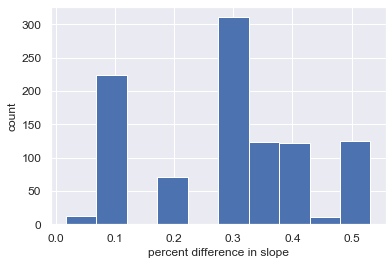

In [20]:
# ADDITION: Elene distribution (Fig. S1)
raw_data_elene = parttest('elene',10)

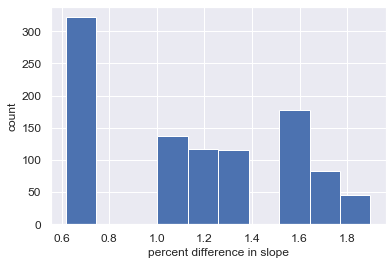

In [21]:
# ADDITION: Juliana distribution (Fig. S1)
raw_data_juliana = parttest('juliana',10)

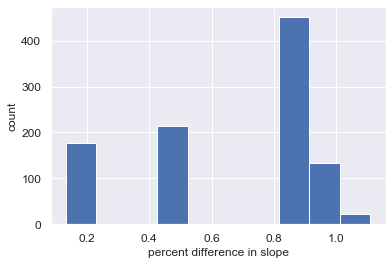

In [22]:
# ADDITION: Christ and Satan distribution (Fig. S1)
raw_data_christandsatan = parttest('christandsatan',10)

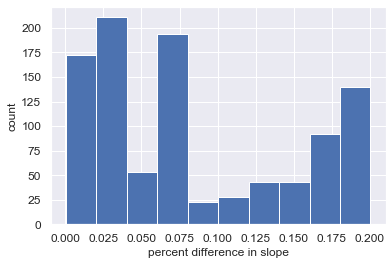

In [23]:
# ADDITION: Andreas distribution (Fig. S1)
raw_data_andreas = parttest('andreas',10)

In [24]:
# ADDITION: Kolmogorov-Smirnov tests comparing the Beowulf distribution with those of the other five texts

print(stats.ks_2samp(raw_data_exodus, raw_data_beowulf))
print(stats.ks_2samp(raw_data_elene, raw_data_beowulf))
print(stats.ks_2samp(raw_data_juliana, raw_data_beowulf))
print(stats.ks_2samp(raw_data_christandsatan, raw_data_beowulf))
print(stats.ks_2samp(raw_data_andreas, raw_data_beowulf))

Ks_2sampResult(statistic=0.8298298298298298, pvalue=0.0)
Ks_2sampResult(statistic=0.933933933933934, pvalue=0.0)
Ks_2sampResult(statistic=1.0, pvalue=0.0)
Ks_2sampResult(statistic=1.0, pvalue=0.0)
Ks_2sampResult(statistic=0.34634634634634637, pvalue=1.5517921218840467e-53)


In [25]:
# ADDITION: Examine all possible combinations of "long" texts

longlocations={};
wanted_keys=[];
for text in locations:
    if len(locations[text])>40 and len(locations[text])<160:
        wanted_keys.append(text)
longlocations=dict((k, locations[k]) for k in wanted_keys)


ii=0;
locations_te={}
for text1 in longlocations:
    for text2 in longlocations:
        if text1!=text2:
            locations_te[ii] = merge([text1,text2], locations, line_counts)
            ii+=1

beowulf2 - christii: slope = 16.71, r = 0.9880883009288538


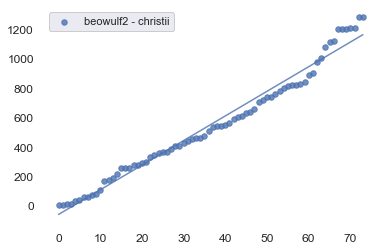

beowulf2 - christiii: slope = 18.94, r = 0.970016700580555


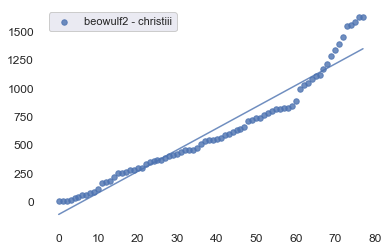

beowulf2 - christandsatan: slope = 18.16, r = 0.9637724460740938


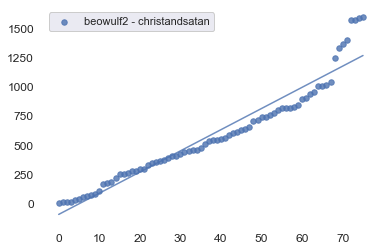

beowulf2 - daniel: slope = 17.84, r = 0.9673971061436927


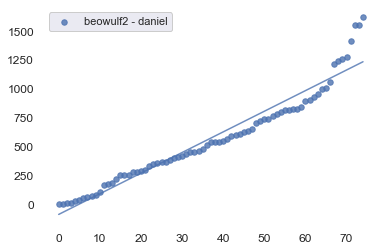

beowulf2 - elene: slope = 20.09, r = 0.9850353097889568


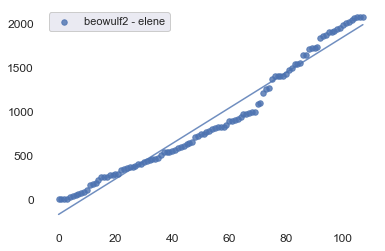

beowulf2 - exodus: slope = 12.25, r = 0.9928708283563059


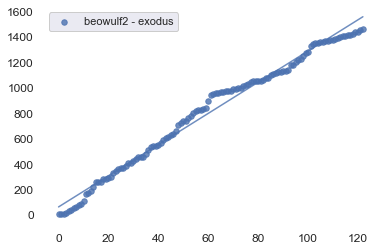

beowulf2 - genesisB: slope = 16.8, r = 0.9884829753309752


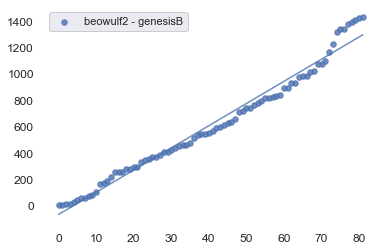

beowulf2 - guthlaca: slope = 18.04, r = 0.960338598717323


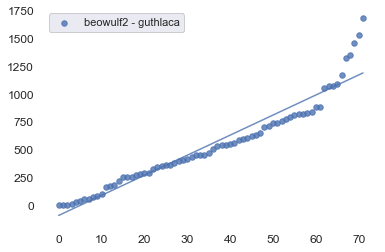

beowulf2 - guthlacb: slope = 16.69, r = 0.9944695372377849


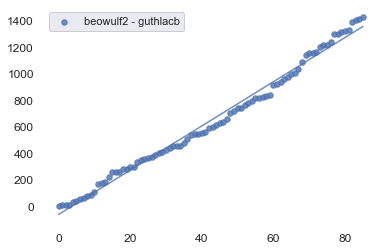

beowulf2 - judith: slope = 15.32, r = 0.9980056923221241


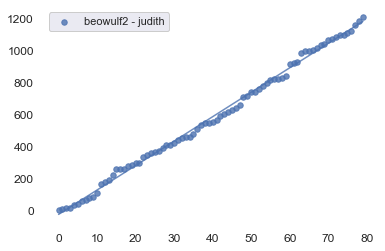

beowulf2 - juliana: slope = 19.63, r = 0.9739326020068069


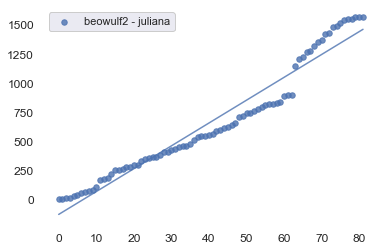

beowulf2 - phoenix: slope = 17.56, r = 0.987889985206002


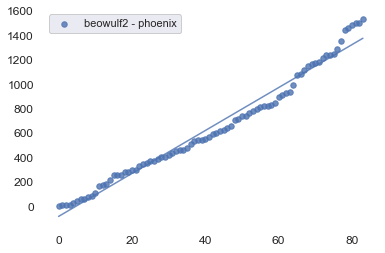

christi - beowulf2: slope = 15.83, r = 0.9944162635541361


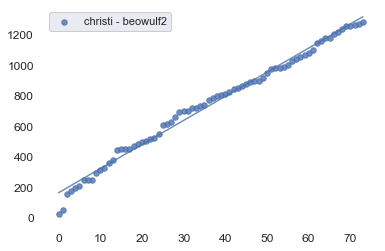

christi - christii: slope = 30.91, r = 0.9901064324224079


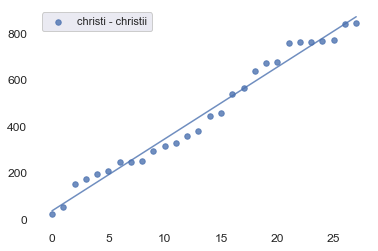

christi - christiii: slope = 38.1, r = 0.9889963362486357


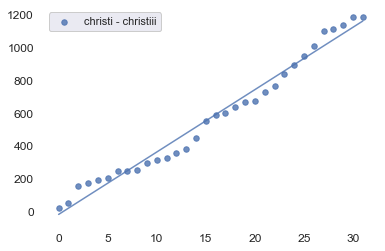

christi - christandsatan: slope = 38.04, r = 0.9668484465899071


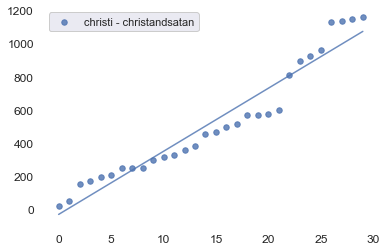

christi - daniel: slope = 37.43, r = 0.9699961771174505


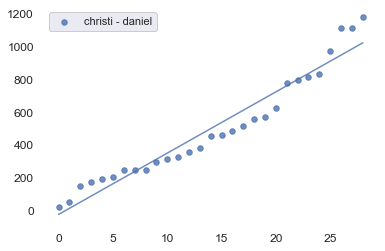

christi - elene: slope = 27.8, r = 0.9956640225753507


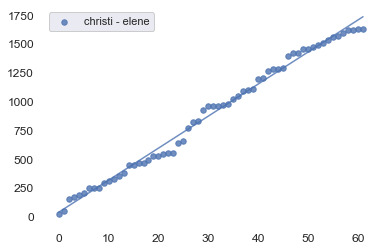

christi - exodus: slope = 11.25, r = 0.9767269764553143


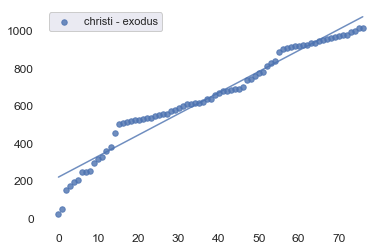

christi - genesisB: slope = 27.2, r = 0.9922341721058032


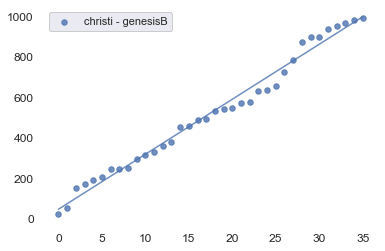

christi - guthlaca: slope = 42.07, r = 0.9609982349671878


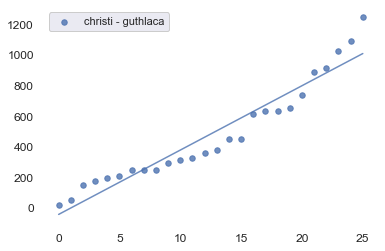

christi - guthlacb: slope = 24.21, r = 0.9948797409577173


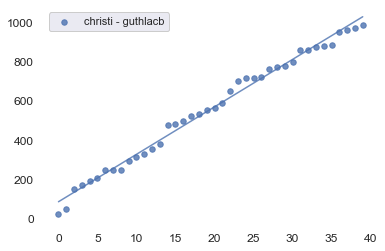

christi - judith: slope = 21.0, r = 0.9823275116870892


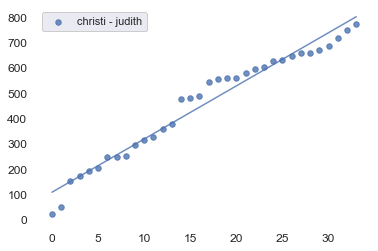

christi - juliana: slope = 35.51, r = 0.9824019424522827


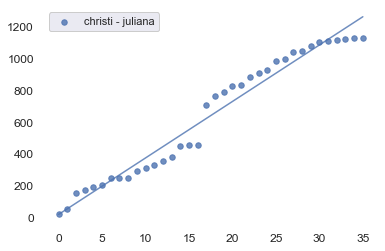

christi - phoenix: slope = 28.26, r = 0.9954446478490969


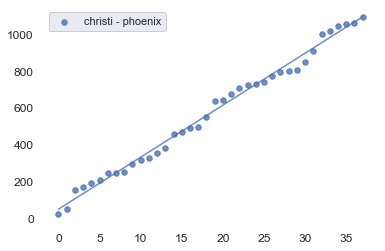

christii - beowulf2: slope = 15.6, r = 0.9931098619294885


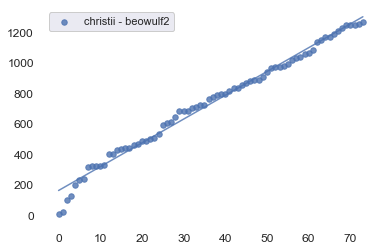

christii - christi: slope = 29.31, r = 0.990555173679117


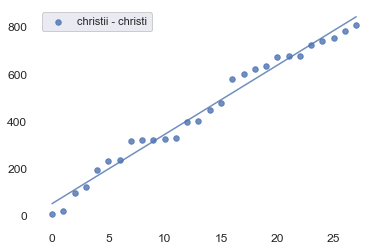

christii - christiii: slope = 37.58, r = 0.9906729229761426


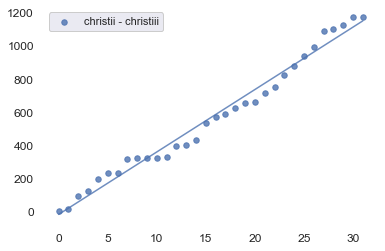

christii - christandsatan: slope = 37.54, r = 0.9671289030826936


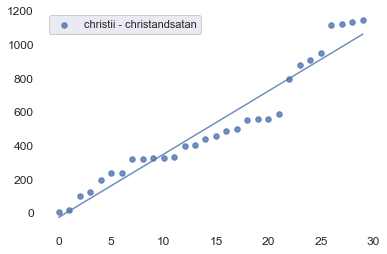

christii - daniel: slope = 36.95, r = 0.9706218524218577


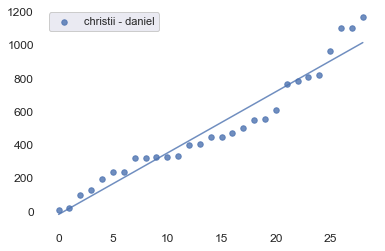

christii - elene: slope = 27.5, r = 0.9950570369579237


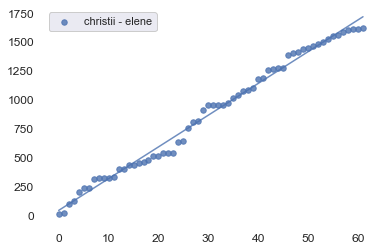

christii - exodus: slope = 11.04, r = 0.9743836710861707


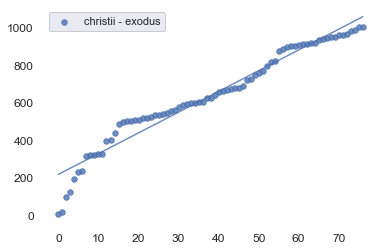

christii - genesisB: slope = 26.68, r = 0.9892876210155934


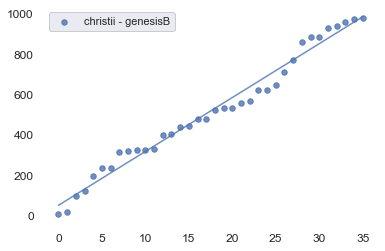

christii - guthlaca: slope = 41.71, r = 0.9650764228318436


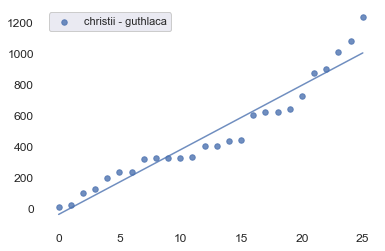

christii - guthlacb: slope = 23.71, r = 0.9928526129755246


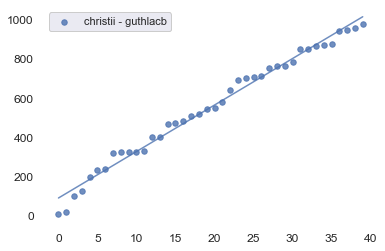

christii - judith: slope = 20.47, r = 0.9752967620901049


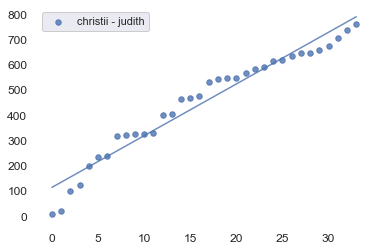

christii - juliana: slope = 34.99, r = 0.9840911821826986


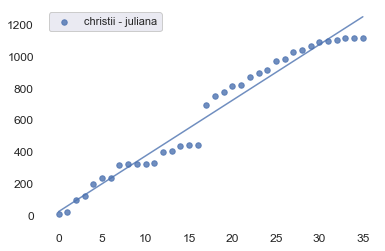

christii - phoenix: slope = 27.76, r = 0.9943490109100931


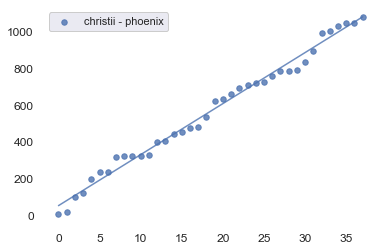

christiii - beowulf2: slope = 18.44, r = 0.9722514136010277


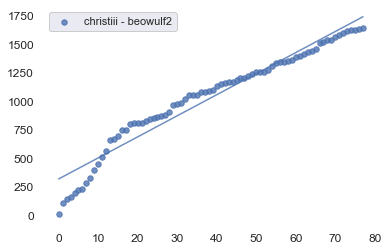

christiii - christi: slope = 39.17, r = 0.9895198672744825


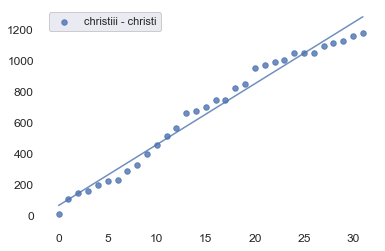

christiii - christii: slope = 40.02, r = 0.9924903024886376


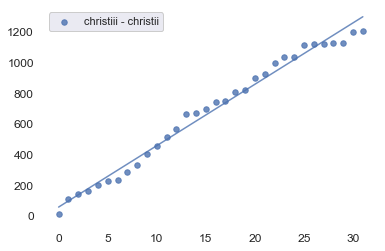

christiii - christandsatan: slope = 44.78, r = 0.9900717739390309


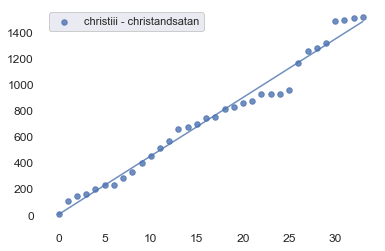

christiii - daniel: slope = 44.63, r = 0.9920994780259813


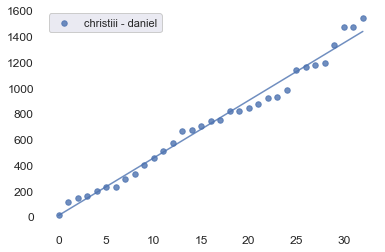

christiii - elene: slope = 30.57, r = 0.9934190155275618


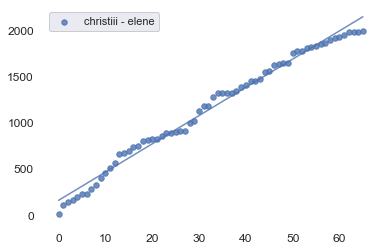

christiii - exodus: slope = 13.93, r = 0.9363267626600286


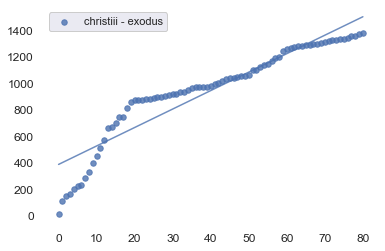

christiii - genesisB: slope = 33.9, r = 0.9901180908591873


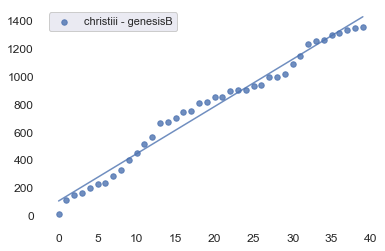

christiii - guthlaca: slope = 49.56, r = 0.9895535032309385


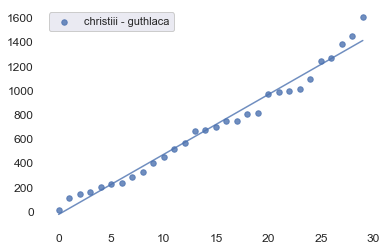

christiii - guthlacb: slope = 30.45, r = 0.9815029533768104


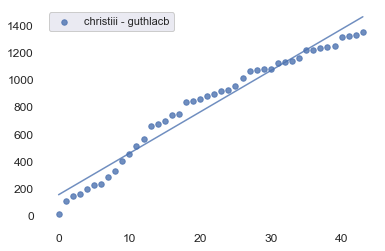

christiii - judith: slope = 29.44, r = 0.96486055623695


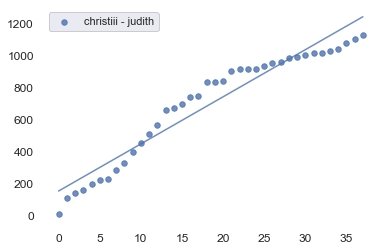

christiii - juliana: slope = 41.56, r = 0.9876432009755606


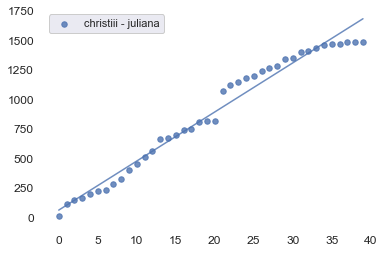

christiii - phoenix: slope = 34.45, r = 0.9906536735744955


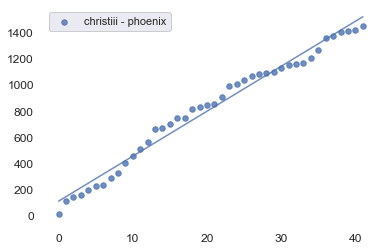

christandsatan - beowulf2: slope = 18.46, r = 0.9625870633977116


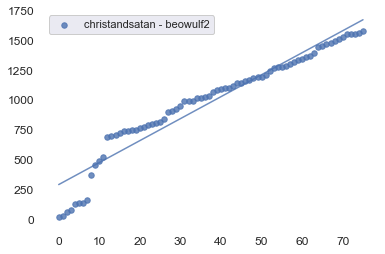

christandsatan - christi: slope = 42.14, r = 0.974924734596468


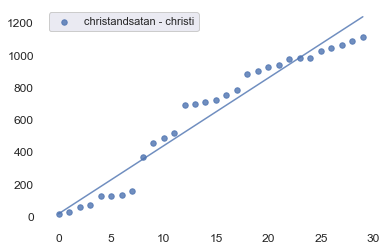

christandsatan - christii: slope = 43.13, r = 0.9795711287137754


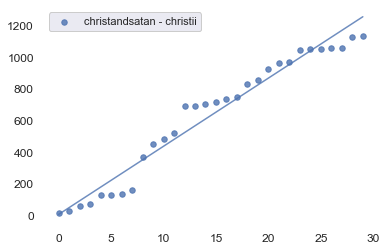

christandsatan - christiii: slope = 47.38, r = 0.9923025793971733


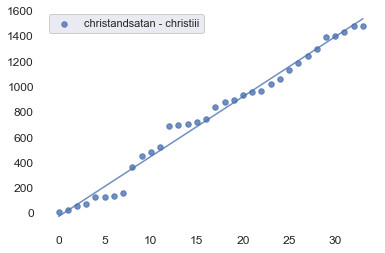

christandsatan - daniel: slope = 48.19, r = 0.9868558869903413


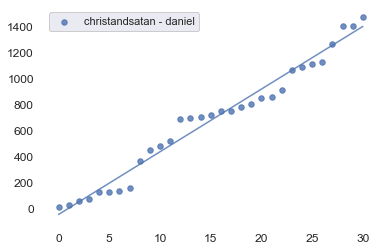

christandsatan - elene: slope = 31.04, r = 0.9886499819512166


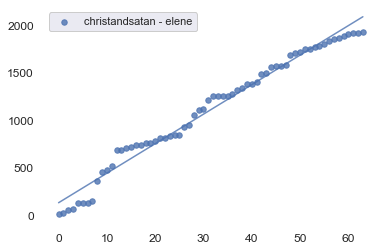

christandsatan - exodus: slope = 13.82, r = 0.9213092121584254


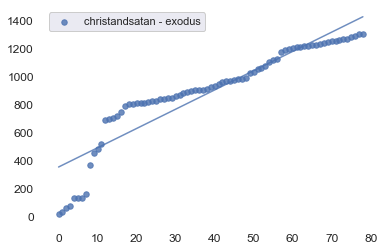

christandsatan - genesisB: slope = 35.54, r = 0.9775694654839098


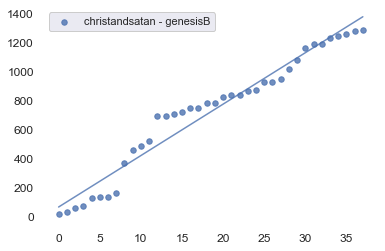

christandsatan - guthlaca: slope = 54.35, r = 0.9872600975693568


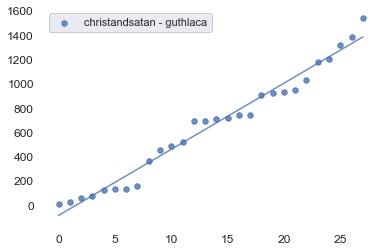

christandsatan - guthlacb: slope = 31.49, r = 0.9666771887004605


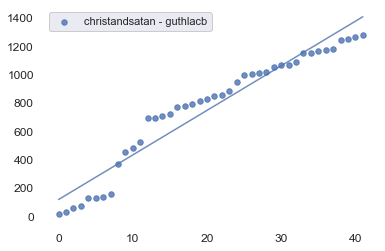

christandsatan - judith: slope = 30.78, r = 0.9419372572981024


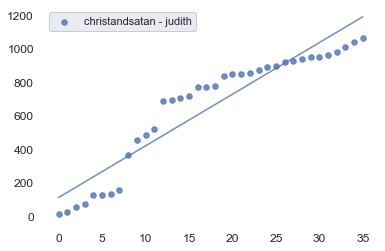

christandsatan - juliana: slope = 43.54, r = 0.9797241646939683


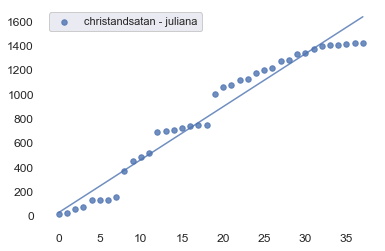

christandsatan - phoenix: slope = 35.9, r = 0.9793226844043147


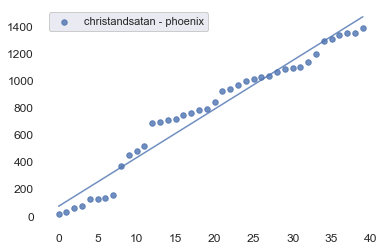

daniel - beowulf2: slope = 19.14, r = 0.960400479384781


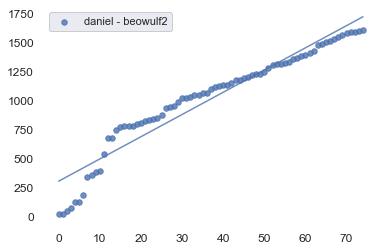

daniel - christi: slope = 45.74, r = 0.9796133516593113


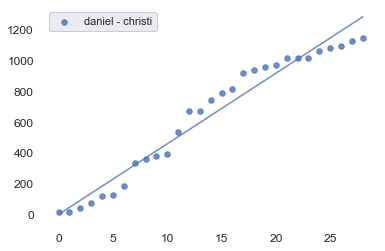

daniel - christii: slope = 46.81, r = 0.9845547421638213


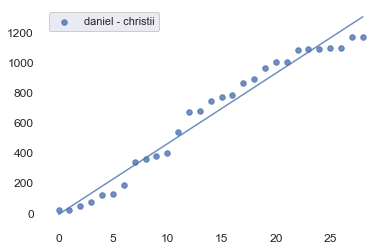

daniel - christiii: slope = 50.84, r = 0.9946252425425975


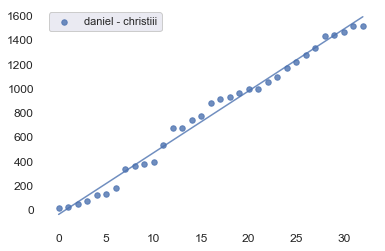

daniel - christandsatan: slope = 51.98, r = 0.9910772424872227


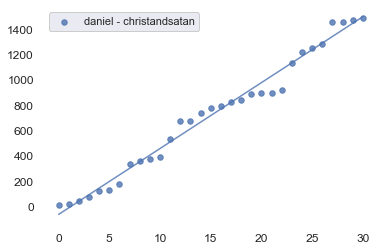

daniel - elene: slope = 32.15, r = 0.988064632257213


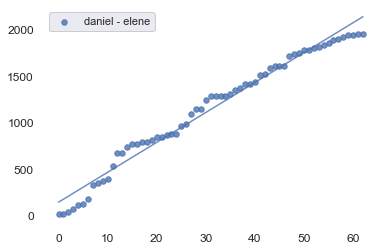

daniel - exodus: slope = 14.39, r = 0.918627539919972


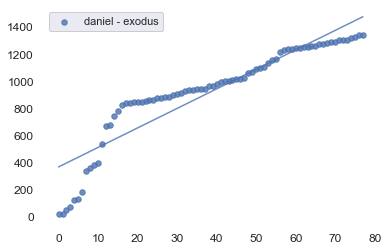

daniel - genesisB: slope = 38.16, r = 0.9823561795603512


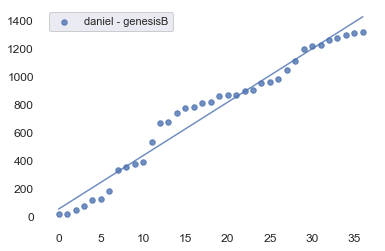

daniel - guthlaca: slope = 58.96, r = 0.9918229919419767


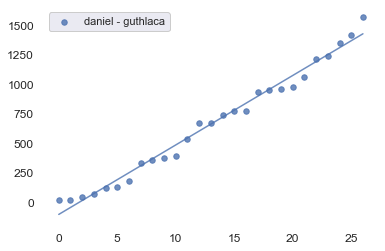

daniel - guthlacb: slope = 33.61, r = 0.9684697650073207


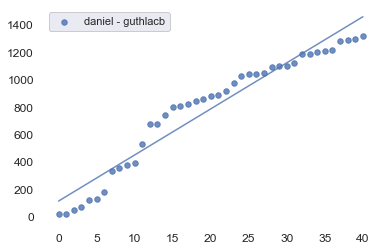

daniel - judith: slope = 33.31, r = 0.9485340765901414


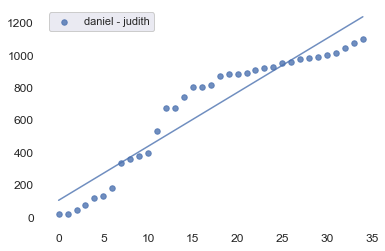

daniel - juliana: slope = 46.32, r = 0.9790835889948962


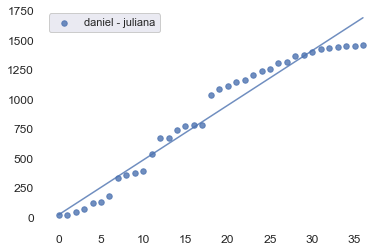

daniel - phoenix: slope = 38.32, r = 0.9814042114544173


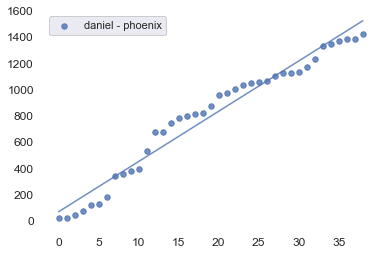

elene - beowulf2: slope = 20.15, r = 0.9850747041280522


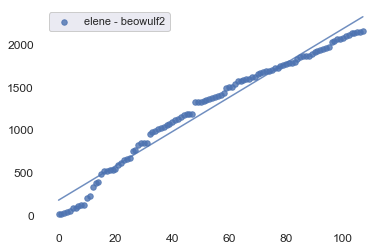

elene - christi: slope = 28.87, r = 0.9958274438228283


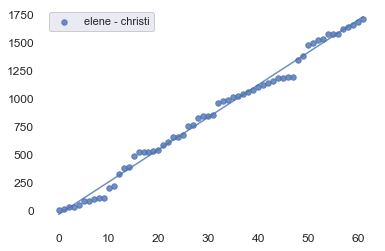

elene - christii: slope = 29.08, r = 0.9956585063370786


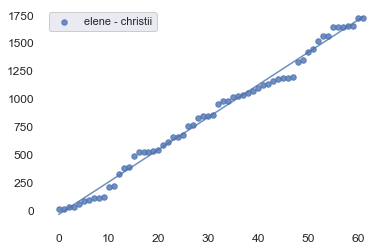

elene - christiii: slope = 31.29, r = 0.9928215031857787


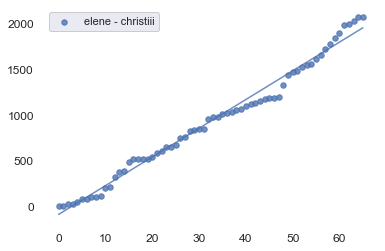

elene - christandsatan: slope = 30.7, r = 0.9888358026713626


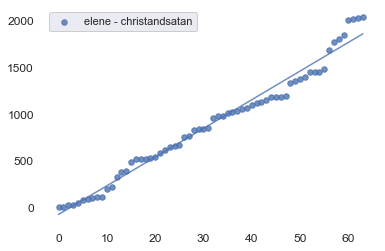

elene - daniel: slope = 30.47, r = 0.9900004987838504


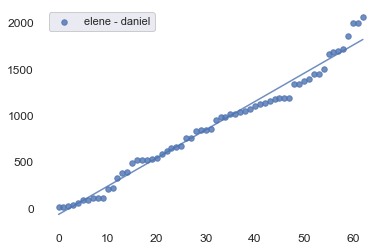

elene - exodus: slope = 17.08, r = 0.9634619736280818


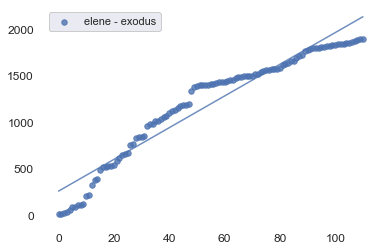

elene - genesisB: slope = 27.65, r = 0.9963710367344862


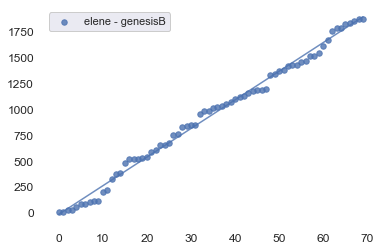

In [26]:
# ADDITION: All 86 composite plots along with slopes 

for ii in range(1,86):
    plot_hapax_curve('all', hapaxes, locations_te[ii], hlines=hlines)

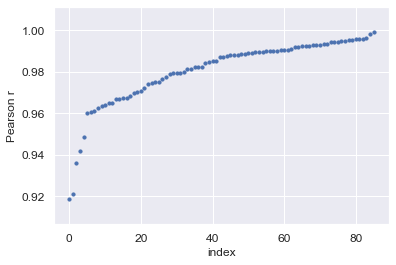

In [27]:
# ADDITION: Plot the full distribution of slopes (Fig. S2)

rvalues=[0.9880883009288538,0.970016700580555,0.9637724460740935,0.9673971061436918,0.9850353097889568,0.992870828356306,0.9884829753309748,0.960338598717323,0.9944695372377848,0.9980056923221242,0.9739326020068066,0.987889985206002,0.9944162635541358,0.9901064324224077,0.9889963362486357,0.9668484465899071,0.9699961771174505,0.9956640225753507,0.9767269764553141,0.9922341721058032,0.9609982349671881,0.9948797409577174,0.9823275116870894,0.9824019424522827,0.9954446478490969,0.9931098619294885,0.990555173679117,0.9906729229761426,0.9671289030826936,0.9706218524218577,0.9950570369579237,0.974383671086171,0.9892876210155933,0.9650764228318434,0.9928526129755246,0.9752967620901049,0.9840911821826986,0.9943490109100932,0.9722514136010278,0.9895198672744825,0.9924903024886376,0.9900717739390309,0.9920994780259813,0.9934190155275618,0.9363267626600288,0.9901180908591872,0.9895535032309387,0.9815029533768101,0.96486055623695,0.9876432009755605,0.9906536735744954,0.9625870633977116,0.9749247345964682,0.9795711287137753,0.9923025793971733,0.9868558869903413,0.9886499819512166,0.9213092121584254,0.97756946548391,0.9872600975693567,0.9666771887004603,0.9419372572981024,0.9797241646939681,0.9793226844043147,0.960400479384781,0.9796133516593115,0.9845547421638213,0.9946252425425971,0.9910772424872227,0.9880646322572126,0.9186275399199716,0.9823561795603512,0.9918229919419769,0.9684697650073211,0.9485340765901414,0.979083588994896,0.9814042114544173,0.9850747041280522,0.9958274438228283,0.9956585063370791,0.9928215031857789,0.9888358026713626,0.9900004987838505,0.9634619736280825,0.996371036734486,0.999185091231145]

plt.rcParams['font.sans-serif'] = "Arial"
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)


sortr=np.sort(rvalues);
f=plt.figure()
plt.scatter(range(0,86),sortr, s=10)

plt.xlabel('index', fontsize=12)
plt.ylabel('Pearson r', fontsize=12)

plt.show()
f.savefig("foo.pdf", bbox_inches='tight')